In [337]:
include("../code/bp_full.jl")
include("../code/optimal_cycle.jl")
using ProgressMeter, StatsBase

### 1. Draw random instance and find ground state

In [338]:
# Build a random graph with variables of degree exactly 2
# Inputs: size, rate

include("../code/ldpc_graph.jl")
function cycle_code(n::Int, R::Real; rng=MersenneTwister(0))
    @assert 0≤R≤1
    m = round(Int, n*(1-R))
    nedges, Lambda, Rho = generate_polyn(n,m,degree_type=:nodes)
    nedges = 2n
    H = permutedims(ldpc_matrix(n,m,nedges,Lambda,Rho, accept_multi_edges=false,rng=rng))
end

cycle_code (generic function with 1 method)

In [354]:
n = 100
R = 0.5
rng = MersenneTwister(2)
H = cycle_code(n, R; rng=rng)
x0 = bitrand(rng, n)   # source
d, dist, x_gs = findsol(H, x0, weights=zeros(Int,n))

Iter 1. Distortion 0.16. Cycle weight -56.0. Energy shift -28
Iter 2. Distortion 0.16. Cycle weight 0.0. Energy shift 0


(0.16, [0.16, 0.16, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], Bool[1, 0, 0, 0, 0, 0, 1, 1, 1, 0  …  0, 1, 0, 1, 1, 1, 1, 0, 0, 0])

### 2. Find the energy shift to the first excited state
(Re-run the code if ground state degenerate)

In [355]:
# Given a ground state config `x_gs`, the energy of the first excited state:
# Force each variable in turn to take value opposite to what it had in `x_gs`,
#  then find the optimal solution with that variable constraint
# `x0` is the source

function first_excited(H::SparseMatrixCSC, x_gs::AbstractVector, x0::AbstractVector)
    n = length(x_gs)
    x = copy(x_gs)
    # w=1 does nothing
    w = ones(Int, n)  
    d = zeros(n)
    @showprogress for i in 1:n
        x .= x_gs
        # set weight large enough to force flipping of x[i]
        w[i] = -n
        # find optimal solution using the mapping to perfect matching
        d[i], _, _ = findsol(H, x0, x, weights=w, verbose=false)
        @assert x[i] != x_gs[i]
        # set weight back to default
        w[i] = 1
    end
    d
end

first_excited (generic function with 1 method)

In [356]:
D = first_excited(H, x_gs, x0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [357]:
d, minimum(D)

(0.16, 0.17)

In [358]:
ϵ = minimum(D) - d

0.010000000000000009

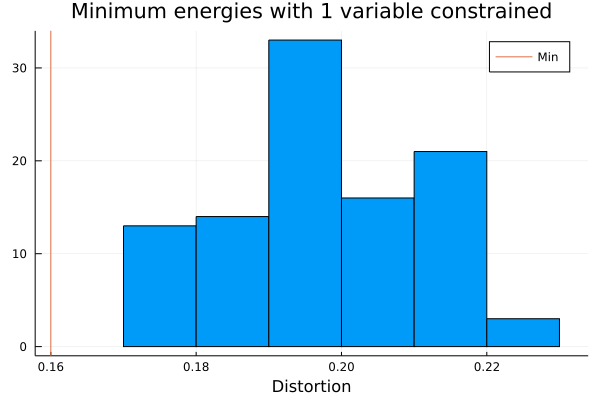

In [359]:
using Plots
histogram(D, label="")
vline!([d], label="Min")
xlabel!("Distortion")
title!("Minimum energies with 1 variable constrained")

### 3. Run MaxSum
for $k=\biggl\lceil\frac{nw^*}{\epsilon}\biggr\rceil$ iterations where $w^*=2$ is the maximum reward for flipping a variable

In [360]:
s = (-1) .^ x0
efield = [(ss,-ss) for ss in s]
ms = BPFull(H, efield)
wstar = 2
k = ceil(Int, wstar*n/ϵ)

20000

In [361]:
global dist = fill(NaN, k)
global nunsat = fill(NaN, k)

function cb(it, ε, bp)
    mod(it, 10^4)==0 && println("Iter $it.\terr=$ε")
    s = map(t->sign(t[1]-t[2]), bp.efield)
    nunsat_, _,dist_ = performance(bp, s)
    nunsat[it] = nunsat_; dist[it] = dist_
    decvars = argmax.(bp.belief) .== 2
    decvars == x && return true
    false
end
err, iters = iteration_ms!(ms, maxiter=k, tol=1e-15, callback=cb)

Iter 10000.	err=2.0
Iter 20000.	err=2.0


(2.0, 20000)

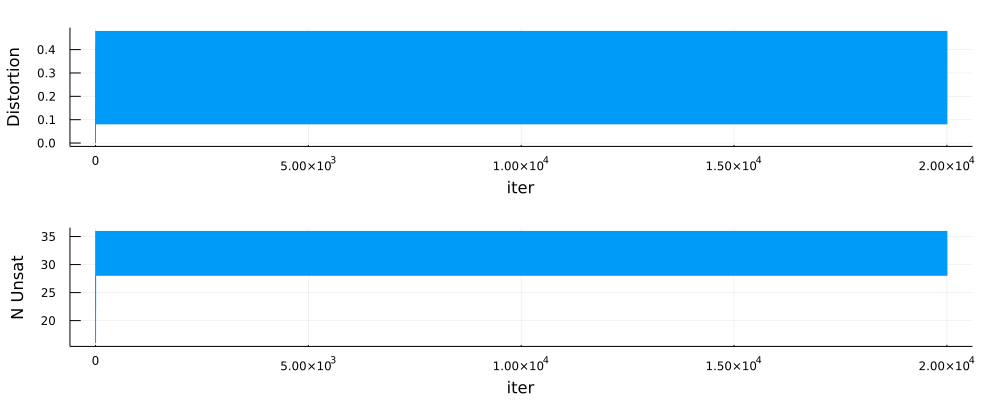

In [362]:
p1 = plot(dist, label="")
xlabel!(p1, "iter")
ylabel!(p1, "Distortion")
p2 = plot(nunsat, label="")
xlabel!(p2, "iter")
ylabel!(p2, "N Unsat")
plot(p1,p2,layout=(2,1), size=(1000,400), margin=5Plots.mm)

In [368]:
x_ms = (argmax.(ms.belief) .== 2)
beliefs = [t[1]-t[2] for t in ms.belief]
beliefs_hist = sort(proportionmap(beliefs))

OrderedCollections.OrderedDict{Int64, Float64} with 4 entries:
  -6 => 0.06
  -2 => 0.42
  2  => 0.46
  6  => 0.06

In [364]:
a,b,c = performance(ms, s)
println(a, " unsat. Distance of decision vars from source = ", c)

28 unsat. Distance of decision vars from source = 0.48


In [365]:
x_optimal == x_ms

false